In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
import torch
from keras import *
import random
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.2/Xtrain_Classification2.npy'))
y_train = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.2/ytrain_Classification2.npy'))
X_test  = np.load(os.path.abspath('/content/drive/MyDrive/Machinelearning5.2/Xtest_Classification2.npy'))

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
a = dict(zip(unique, counts))
a

{0.0: 5362, 1.0: 890, 2.0: 116, 3.0: 2305, 4.0: 990, 5.0: 966}

In [ ]:
116*100/y_train.shape[0]

1.0913538432590084

In [ ]:
#metrics

from keras import backend as k
def onehot(y_onehot):
    y = y_onehot[:,1]
    return y

def specificity_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = k.sum(neg_y_true * y_pred)
    tn = k.sum(neg_y_true * neg_y_pred)
    return tn / (tn + fp)

def sensitivity_custom(y_pred_onehot, y_true_onehot): #sensitivity=recall
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_pred = 1 - y_pred
    fn = k.sum(neg_y_pred*y_true)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred, y_true):
    specificity_val = specificity_custom(y_pred, y_true)
    sensitivity_val = sensitivity_custom(y_pred, y_true)
    return (specificity_val + sensitivity_val)/2


def precision_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    fp = k.sum(neg_y_true * y_pred)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fp)

def balanced_accuracy_enunciado(y_pred, y_true):
    precision_val = precision_custom(y_pred, y_true)
    recall_val = sensitivity_custom(y_pred, y_true)#sensitivity=recall
    return (precision_val + recall_val)/2



def learning_rate_scheduler_function(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95  # Adjust the rate as needed




In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_balanced_accuracy_custom') >= 0.85:
            self.model.stop_training = True

from sklearn.utils import class_weight

def weighted_balance(y_Data_hotencoded):
    y_Data=np.argmax(y_Data_hotencoded,1).copy()
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))

In [ ]:
def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):

    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)



In [ ]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    fig.suptitle('Model Evaluation',)

    best_bacc =round(max(dtf.iloc[:,8]),4)
    #best_bacc =round((dtf.iloc[:,7]).nlargest().sum/5,4)


    ax1.plot(dtf.iloc[:,8],'bo--',label=f'Validation Balanced Accuracy - best: {best_bacc} ')
    ax1.plot(dtf.iloc[:,3],'go--',label=f'Train Balanced Accuracy')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,5],'go--',label=f'Validation Loss')
    ax2.plot(dtf.iloc[:,0],'ro--',label=f'Train Loss')
    ax2.legend()
    ax2.set_xlabel('Epochs')


    plt.show()



    f1_score = dtf.iloc[-1,9]
    print('validation f1:', f1_score )


    return best_bacc, f1_score

In [ ]:
#model 1
def model_def1(optimizer_string, loss_string, nrclasses):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.2))


    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.2))
    model_img.add(layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(nrclasses, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            loss = loss_string,
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom,keras.metrics.F1Score() ]
        )
    return model_img

In [ ]:
#model 2
def model_def2(optimizer_string, loss_string, nrclasses):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.3))


    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.3))
    model_img.add(layers.Dense(512, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(nrclasses, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            loss = loss_string,
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom,keras.metrics.F1Score() ]
        )
    return model_img


In [ ]:
#model 3
def model_def3(optimizer_string, loss_string, nrclasses):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.3))


    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.3))
    model_img.add(layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(nrclasses, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            loss = loss_string,
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, keras.metrics.F1Score()]
        )
    return model_img

In [ ]:
#model 4
def model_def4(optimizer_string, loss_string, nrclasses):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.3))


    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.3))
    model_img.add(layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(nrclasses, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            loss = loss_string,
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom,keras.metrics.F1Score() ]
        )
    return model_img


In [ ]:
### Neural Network
#equal to model def 1
def model_def5(optimizer_string, loss_string, nrclasses):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Dropout(0.2))


    model_img.add(layers.Flatten())
    model_img.add(layers.Dropout(0.5))
    model_img.add(layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'))
    model_img.add(layers.Dense(nrclasses, activation='softmax'))

    model_img.compile(
            optimizer = optimizer_string,
            loss = loss_string,
            metrics=[specificity_custom, sensitivity_custom ,balanced_accuracy_custom, keras.metrics.F1Score() ]
        )
    return model_img

In [ ]:


def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch, x_all, y_all,classweight_bool, nrclasses, i, x_val, y_val):

    if i==1:
      model = model_def1(optimizer_string, loss_string, nrclasses)
    elif i==2:
      model = model_def2(optimizer_string, loss_string, nrclasses)
    elif i==3:
      model = model_def3(optimizer_string, loss_string, nrclasses)
    elif i==4:
      model = model_def4(optimizer_string, loss_string, nrclasses)
    elif i==5:
      model = model_def5(optimizer_string, loss_string, nrclasses)

    callback = CustomCallback()
    lr_callback = LearningRateScheduler(learning_rate_scheduler_function)


    if classweight_bool:
        class_weights=weighted_balance(y_all)
    else:
        class_weights =None

    model_history = model.fit(
        x_all, y_all,
        batch_size=batch,
        epochs=epoch_nr,
        validation_data=(x_val, y_val),
        class_weight = class_weights, callbacks=[callback, lr_callback])


    best_balancedAccuracy, f1_score = plot_neuralmodel(model_history)
    #save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy)
    return model, model_history, f1_score

** **

**Running the 5 CNNs**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

def data_balance_generator(Xtrain, train_labels, num_classes):
    Xtrain = Xtrain.reshape(-1, 28, 28, 3) # Reshape the input data

    train_labels = np.argmax(train_labels, axis=1) # Convert one-hot encoded labels to categorical labels (0 to num_classes-1)
    train_labels = tf.cast(train_labels, dtype=tf.float32)

    train_labels = keras.utils.to_categorical(train_labels, num_classes) # Reshape the labels back to one-hot encoding

    # Use RandomOverSampler to balance the dataset
    ros = RandomOverSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ros.fit_resample(Xtrain.reshape(-1, 28 * 28 * 3), train_labels)

    X_resampled = X_resampled.reshape(-1, 28, 28, 3) # Reshape X_resampled back to its original shape

    return X_resampled, y_resampled

def usar_oversample(x,y):
    # Use RandomOverSampler to balance the dataset
    ros = RandomOverSampler(sampling_strategy='auto')
    X_resampled, y_oversample = ros.fit_resample(x.reshape(x.shape[0], 28 * 28 * 3), y)

    x_oversample = X_resampled.reshape(X_resampled.shape[0], 28, 28, 3) # Reshape X_resampled back to its original shape

    return x_oversample, y_oversample
def shuffle_data(x, y):
    permutation = np.random.permutation(len(x))
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    return x_shuffled, y_shuffled
def x_y_preprocessing(x,y, validation_size):
    X_train_normalizado= x/255
    x_shuffled, y_shuffled = shuffle_data(X_train_normalizado,y)
    X_train, X_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=validation_size)

    X_train_sample = np.reshape(X_train,(X_train.shape[0],28,28,3))
    x_val_sample = np.reshape(X_val,(X_val.shape[0],28,28,3))

    y_train_2labels = keras.utils.to_categorical(y_train, num_classes=6)
    y_val_2labels = keras.utils.to_categorical(y_val, num_classes=6)
    x_fds , yfds = data_balance_generator(X_train,y_train_2labels,6)
    X_train_sample_over, y_train_2labels_over= shuffle_data(x_fds , yfds)

    y_train_32 = tf.convert_to_tensor(y_train_2labels_over, dtype=tf.float32)  # Cast y_train to float32


    return  X_train_sample_over, y_train_32, x_val_sample , y_val_2labels

In [ ]:
x,y,xv,yv=x_y_preprocessing(X_train,y_train,0.2)
print(X_train.shape, x.shape, xv.shape)
print(y_train.shape, y.shape, yv.shape)
y_train_2labels = keras.utils.to_categorical(y_train, num_classes=6)

print('y_train')
for i in range(6):
  print(f'Classe{i}',np.sum(y_train_2labels[:,i]),round(np.sum(y_train_2labels[:,i])/y_train_2labels.shape[0],2))

print('Y_trainoversample')
for i in range(6):
  print(f'Classe{i}',np.sum(y[:,i]),round(np.sum(y[:,i])/y.shape[0],2))

print('y_val')
for i in range(6):
  print(f'Classe{i}',round(np.sum(yv[:,i])/yv.shape[0],2))


In [ ]:
X_train_sample, y_train_sample, x_val , y_val= x_y_preprocessing(X_train, y_train, 0.2)

x_prediction = X_test.reshape((X_test.shape[0],28,28,3)).copy()
x_pred = x_prediction/255

from sklearn.metrics import confusion_matrix

y_true = np.argmax (y_val, axis = 1)
model=[None]*5
model_history=[None]*5
f1_scores=[None]*5
y_pred_test=[None]*5
y_pred_val=[None]*5
results_val=[None]*5
confusion_matrix_val=[None]*5

for i in range(5):
  print(f'Model {i+1}')
  model[i], model_history[i], f1_scores[i] = neural_defandTrain("adam", "categorical_crossentropy",300,256, X_train_sample, y_train_sample, True, 6,i+1, x_val , y_val)
  y_pred_test[i] = model[i].predict(x_pred)
  y_pred_val[i] = model[i].predict(x_val)

  np.save(f'Results_modeltest{i}',y_pred_test[i])

  results_val[i] = np.argmax(y_pred_val[i],1).copy()
  confusion_matrix_val[i] = confusion_matrix(y_true, results_val[i] , normalize='pred')
  print(confusion_matrix_val[i])






The results above are very long but very important - the terminal output has f1 values, balaced accuracy and loss graphs and confusion matrixes for all 5 models. These results were saved in a .pdf file that is in this project's delivery .zip file

**Predictions**

In [ ]:
final_pred_val = (y_pred_val[0] + y_pred_val[1] + y_pred_val[2] + y_pred_val[3] + y_pred_val[4])/5
final_pred_val_vector = np.argmax(final_pred_val,1)

confusion_matrix_final = confusion_matrix(y_true, final_pred_val_vector, normalize='pred')
print(confusion_matrix_final)

[[0.94017094 0.38020833 0.28571429 0.         0.         0.        ]
 [0.05508072 0.59895833 0.03571429 0.0021097  0.         0.        ]
 [0.00474834 0.02083333 0.67857143 0.         0.         0.        ]
 [0.         0.         0.         0.96413502 0.04761905 0.03157895]
 [0.         0.         0.         0.01898734 0.94708995 0.02105263]
 [0.         0.         0.         0.01476793 0.00529101 0.94736842]]


In [ ]:
y_prection_onehotencoded = (y_pred_test[0] + y_pred_test[1] + y_pred_test[2] + y_pred_test[3] + y_pred_test[4])/5
delivery_results = np.argmax(y_prection_onehotencoded,1)
np.save('MLprediction_100123_100260_5.2',delivery_results)

In [ ]:
a=np.load(os.path.abspath('/content/MLprediction_100123_100260_5.2.npy'))
a.shape


(2658,)

In [ ]:

#testing oversampling

X_train_sample, y_train_sample, x_val , y_val= x_y_preprocessing(X_train, y_train, 0.2)
x_prediction = X_test.reshape((X_test.shape[0],28,28,3)).copy()
x_pred = x_prediction/255
from sklearn.metrics import confusion_matrix
y_true = np.argmax (y_val, axis = 1)
model=[None]
model_history=[None]
f1_scores=[None]
y_pred_test=[None]
y_pred_val=[None]
results_val=[None]
confusion_matrix_val=[None]
i=0
print(f'Model {i+1}')
model, model_history, f1_scores = neural_defandTrain("adam", "categorical_crossentropy",300,256, X_train_sample, y_train_sample, True, 6,i+1, x_val , y_val)
y_pred_test = model.predict(x_pred)
y_pred_val = model.predict(x_val)

np.save(f'Results_modeltest{i}',y_pred_test[i])

results_val = np.argmax(y_pred_val,1).copy()
confusion_matrix_val = confusion_matrix(y_true, results_val , normalize='pred')
print(confusion_matrix_val)

**Confusion Matrix**


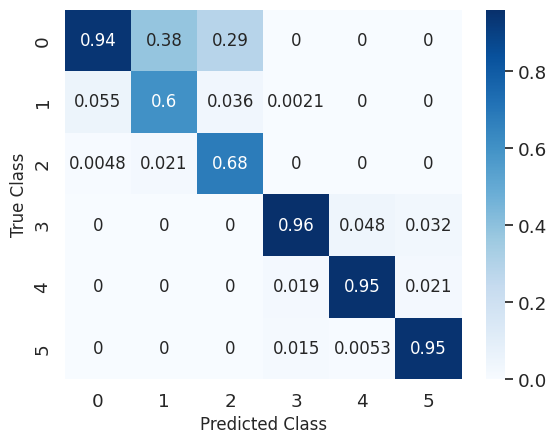

In [ ]:
#ENSEMBLE CONFUSION MATRIX
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array =[[0.94,0.38,0.2857,0.,0.,0.],[0.055,0.6,0.036,0.00211,0.,0.],[0.0048,0.021,0.68,0.,0.,0.],
 [0.,0.,0.,0.96,0.048,0.0316],
 [0.,0.,0.,0.019,0.95,0.0211],
 [0.,0.,0.,0.015,0.00529,0.9474]]

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="Blues") # font size
s.set_ylabel('True Class', fontsize=12)
s.set_xlabel('Predicted Class', fontsize=12)

plt.show()

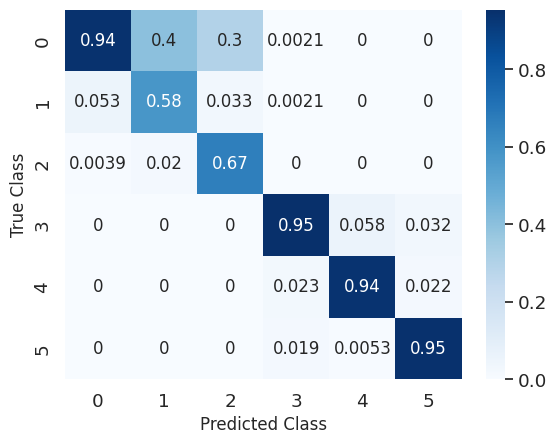

In [ ]:
#MODEL 1 CONFUSION MATRIX
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array =[[0.943,0.399,0.3,0.0021,0.,0.],
 [0.053,0.58,0.0333,0.0021,0.,0.,],
 [0.00385,0.0197,0.667,0.,0.,0.],
 [0.,0.,0.,0.954,0.058,0.032],
 [0.,0.,0.,0.0231,0.94,0.022],
 [0.,0.,0.,0.019,0.0053,0.95]]


df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="Blues") # font size
s.set_ylabel('True Class', fontsize=12)
s.set_xlabel('Predicted Class', fontsize=12)

plt.show()